In [1]:
# ## Import Libraries

# Standard Libraries
import time
import warnings

# Scientific Libraries
import numpy as np
import pandas as pd
import torch

# Sklearn
from sklearn.preprocessing import StandardScaler

# Torch Tools
from torch.utils.tensorboard import SummaryWriter

# Custom Utilities
from utils.dl_helper_functions import (
    convert_to_tensors,
    create_sequences,
    load_picture_lagged_data,
    scale_data,
    scale_data_parallel
)

from utils.Model_Training import training_ConvLSTM_Regression_Classification

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns in pandas
pd.options.display.max_columns = None

# TensorBoard writer
writer = SummaryWriter()

# Define global constants
DTYPE_NUMPY = np.float32              # Datentyp für numpy Arrays
n_jobs = -1                           # Anzahl CPUs für parallele Prozesse
HORIZON = 12                          # 1 Tag Vorhersagehorizont
INITIAL_TRAINING_SIZE = 24 * 183     # 6 Monate Trainingsdaten (4392 Stunden)
SEQUENCE_LENGTH = 24                 # 1 Tag als Input-Sequenz

# Load data
X, y_lagged, y, common_time = load_picture_lagged_data(
    return_common_time=True,
    verbose=False,
    grid_size=25,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    pca=True
)


100%|██████████| 20161/20161 [00:19<00:00, 1023.66it/s]


                 time  bottomT_PC_1  bottomT_PC_2  sla_PC_1  sla_PC_2  \
0 2022-12-04 00:00:00     -0.253416      1.534444 -1.101478 -0.983781   
1 2022-12-04 01:00:00     -0.255468      1.531525 -1.113814 -0.953553   
2 2022-12-04 02:00:00     -0.256922      1.531696 -1.120626 -0.934821   
3 2022-12-04 03:00:00     -0.258302      1.532563 -1.126515 -0.948626   
4 2022-12-04 04:00:00     -0.260158      1.533539 -1.137048 -1.001083   

   sla_PC_3   so_PC_1   so_PC_2   so_PC_3   so_PC_4   so_PC_5   so_PC_6  \
0  0.057865 -0.035018 -0.725962  0.814685 -0.760056  0.076901 -1.407452   
1  0.042919 -0.027256 -0.726845  0.829856 -0.733564  0.140315 -1.440023   
2  0.018273 -0.018038 -0.742140  0.845300 -0.727039  0.207431 -1.448794   
3 -0.023366 -0.011110 -0.757386  0.859283 -0.731314  0.267628 -1.440177   
4 -0.090753 -0.006986 -0.771693  0.868856 -0.730301  0.327864 -1.421779   

    so_PC_7   so_PC_8   so_PC_9  so_PC_10  sob_PC_1  sob_PC_2  sob_PC_3  \
0  1.612081 -0.174459 -1.935842  0.

In [2]:
X.shape, y_lagged.shape, y.shape, common_time.shape

((20137, 66), (20137, 24), (20137,), (20137,))

In [3]:
df_X = pd.DataFrame(X, columns=[f"feature_{i+1}" for i in range(X.shape[1])])
df_X["time"]= common_time
df_X['time'] = pd.to_datetime(df_X['time'], unit='s')
df_X.set_index('time', inplace=True)

df_y_lagged = pd.DataFrame(y_lagged, columns=[f"lagged_{i+1}" for i in range(y_lagged.shape[1])])
df_y_lagged['time'] = common_time
df_y_lagged['time'] = pd.to_datetime(df_y_lagged['time'], unit='s')
df_y_lagged.set_index('time', inplace=True)

df_y = pd.DataFrame(y, columns=["target"])
df_y['time'] = common_time
df_y['time'] = pd.to_datetime(df_y['time'], unit='s')
df_y.set_index('time', inplace=True)

display(df_X.head())
display(df_y_lagged.head())
display(df_y.head())

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-04 00:00:00,-0.253416,1.534444,-1.101478,-0.983781,0.057865,-0.035018,-0.725962,0.814685,-0.760056,0.076901,-1.407452,1.612081,-0.174459,-1.935842,0.151983,0.132604,-0.121734,-0.823899,1.766953,0.591884,1.134544,-0.606230,-0.566720,-0.484530,2.186574,-0.596627,0.688256,1.317784,1.346617,0.489231,-0.529996,0.561417,-0.369464,-1.756551,-1.027955,-1.861164,-0.814350,-2.429856,1.821692,-1.820664,-1.386267,0.401948,1.237698,-0.478852,0.857957,-0.336432,1.419977,1.364076,-0.199675,-2.757992,1.513491,-1.495268,0.249573,0.705704,-0.985003,0.725140,0.966859,-0.205479,0.813762,-1.519170,-0.106194,-0.943929,-0.345346,1.559725,0.767498,0.422216
2022-12-04 01:00:00,-0.255468,1.531525,-1.113814,-0.953553,0.042919,-0.027256,-0.726845,0.829856,-0.733564,0.140315,-1.440023,1.678302,-0.186693,-1.905295,0.057108,0.133896,-0.130167,-0.802071,1.761096,0.600341,1.140432,-0.605314,-0.595861,-0.524285,2.146141,-0.611161,0.697631,1.270784,1.377512,0.525428,-0.525045,0.606906,-0.372759,-1.701597,-1.002948,-1.420331,-0.632467,-1.785778,1.147794,-0.637969,-0.838547,0.823025,0.735022,0.248426,1.187504,0.869649,1.263071,0.165953,-0.138042,-1.529107,1.501762,-1.483587,0.162786,0.506583,-0.926059,0.698191,0.727723,-0.403913,0.841540,-1.531937,-0.144740,-0.927331,-0.332356,1.633660,0.650530,0.350136
2022-12-04 02:00:00,-0.256922,1.531696,-1.120626,-0.934821,0.018273,-0.018038,-0.742140,0.845300,-0.727039,0.207431,-1.448794,1.756310,-0.193616,-1.861856,-0.025771,0.131629,-0.136565,-0.769800,1.756754,0.601060,1.157728,-0.593365,-0.636626,-0.546993,2.122613,-0.637325,0.710357,1.234897,1.415747,0.516135,-0.515825,0.623801,-0.374131,-1.674146,-0.904885,-1.385110,-0.611482,-1.768705,1.052122,-0.509121,-0.782472,0.919105,0.615944,0.394482,1.148568,1.046771,1.250678,-0.008364,-0.109704,-1.500001,1.491229,-1.473191,0.143734,0.447341,-0.971984,0.660237,0.722427,-0.496180,0.655636,-1.549084,-0.123800,-0.949533,-0.328619,1.670766,0.553299,0.358850
2022-12-04 03:00:00,-0.258302,1.532563,-1.126515,-0.948626,-0.023366,-0.011110,-0.757386,0.859283,-0.731314,0.267628,-1.440177,1.829899,-0.194152,-1.801739,-0.060627,0.125973,-0.139658,-0.739839,1.754541,0.597741,1.186321,-0.576108,-0.672662,-0.560464,2.123385,-0.661932,0.724096,1.204076,1.453391,0.486150,-0.512561,0.605648,-0.375355,-1.680642,-0.758290,-1.429147,-0.624831,-1.890221,1.103639,-0.557662,-0.840446,0.964013,0.536090,0.436070,1.121866,1.063898,1.256964,-0.021387,-0.057472,-1.732200,1.478668,-1.460759,0.126259,0.441654,-0.956611,0.553226,0.756676,-0.566558,0.465984,-1.563260,-0.085369,-0.894395,-0.335929,1.671300,0.531151,0.367434
2022-12-04 04:00:00,-0.260158,1.533539,-1.137048,-1.001083,-0.090753,-0.006986,-0.771693,0.868856,-0.730301,0.327864,-1.421779,1.890068,-0.187481,-1.739816,-0.048281,0.116493,-0.140823,-0.722609,1.749118,0.584789,1.225052,-0.569511,-0.690743,-0.570276,2.127633,-0.668462,0.743780,1.168005,1.465315,0.450222,-0.506351,0.535819,-0.376715,-1.733635,-0.617269,-1.473275,-0.670746,-1.994555,1.193554,-0.585438,-0.899838,1.040608,0.490608,0.433253,1.113375,1.056093,1.267134,0.161142,0.032659,-1.945440,1.476656,-1.458904,0.116912,0.482379,-0.891755,0.455828,0.836258,-0.570883,0.235017,-1.573997,-0.034420,-0.827293,-0.34

,lagged_1,lagged_2,lagged_3,lagged_4,lagged_5,lagged_6,lagged_7,lagged_8,lagged_9,lagged_10,lagged_11,lagged_12,lagged_13,lagged_14,lagged_15,lagged_16,lagged_17,lagged_18,lagged_19,lagged_20,lagged_21,lagged_22,lagged_23,lagged_24
time,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-04 00:00:00,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
2022-12-04 01:00:00,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
2022-12-04 02:00:00,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
2022-12-04 03:00:00,0.212980,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
2022-12-04 04:00:00,0.150911,0.212980,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839


,target
time,
2022-12-04 00:00:00,0.344799
2022-12-04 01:00:00,0.285435
2022-12-04 02:00:00,0.212980
2022-12-04 03:00:00,0.150911
2022-12-04 04:00:00,0.090891


In [4]:
# combine X_df and y_lagged_df
df_X = pd.merge(df_X, df_y_lagged, left_index=True, right_index=True).sort_index(ascending=True)
df_X

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,lagged_1,lagged_2,lagged_3,lagged_4,lagged_5,lagged_6,lagged_7,lagged_8,lagged_9,lagged_10,lagged_11,lagged_12,lagged_13,lagged_14,lagged_15,lagged_16,lagged_17,lagged_18,lagged_19,lagged_20,lagged_21,lagged_22,lagged_23,lagged_24
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-04 00:00:00,-0.253416,1.534444,-1.101478,-0.983781,0.057865,-0.035018,-0.725962,0.814685,-0.760056,0.076901,-1.407452,1.612081,-0.174459,-1.935842,0.151983,0.132604,-0.121734,-0.823899,1.766953,0.591884,1.134544,-0.606230,-0.566720,-0.484530,2.186574,-0.596627,0.688256,1.317784,1.346617,0.489231,-0.529996,0.561417,-0.369464,-1.756551,-1.027955,-1.861164,-0.814350,-2.429856,1.821692,-1.820664,-1.386267,0.401948,1.237698,-0.478852,0.857957,-0.336432,1.419977,1.364076,-0.199675,-2.757992,1.513491,-1.495268,0.249573,0.705704,-0.985003,0.725140,0.966859,-0.205479,0.813762,-1.519170,-0.106194,-0.943929,-0.345346,1.559725,0.767498,0.422216,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
2022-12-04 01:00:00,-0.255468,1.531525,-1.113814,-0.953553,0.042919,-0.027256,-0.726845,0.829856,-0.733564,0.140315,-1.440023,1.678302,-0.186693,-1.905295,0.057108,0.133896,-0.130167,-0.802071,1.761096,0.600341,1.140432,-0.605314,-0.595861,-0.524285,2.146141,-0.611161,0.697631,1.270784,1.377512,0.525428,-0.525045,0.606906,-0.372759,-1.701597,-1.002948,-1.420331,-0.632467,-1.785778,1.147794,-0.637969,-0.838547,0.823025,0.735022,0.248426,1.187504,0.869649,1.263071,0.165953,-0.138042,-1.529107,1.501762,-1.483587,0.162786,0.506583,-0.926059,0.698191,0.727723,-0.403913,0.841540,-1.531937,-0.144740,-0.927331,-0.332356,1.633660,0.650530,0.350136,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
2022-12-04 02:00:00,-0.256922,1.531696,-1.120626,-0.934821,0.018273,-0.018038,-0.742140,0.845300,-0.727039,0.207431,-1.448794,1.756310,-0.193616,-1.861856,-0.025771,0.131629,-0.136565,-0.769800,1.756754,0.601060,1.157728,-0.593365,-0.636626,-0.546993,2.122613,-0.637325,0.710357,1.234897,1.415747,0.516135,-0.515825,0.623801,-0.374131,-1.674146,-0.904885,-1.385110,-0.611482,-1.768705,1.052122,-0.509121,-0.782472,0.919105,0.615944,0.394482,1.148568,1.046771,1.250678,-0.008364,-0.109704,-1.500001,1.491229,-1.473191,0.143734,0.447341,-0.971984,0.660237,0.722427,-0.496180,0.655636,-1.549084,-0.123800,-0.949533,-0.328619,1.670766,0.553299,0.358850,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
2022-12-04 03:00:00,-0.258302,1.532563,-1.126515,-0.948626,-0.023366,-0.011110,-0.757386,0.859283,-0.731314,0.267628,-1.440177,1.829899,-0.194152,-1.801739,-0.060627,0.125973,-0.139658,-0.739839,1.754541,0.597741,1.186321,-0.576108,-0.672662,-0.560464,2.123385,-0.661932,0.724096,1.204076,1.453391,0.486150,-0.512561,0.605648,-0.375355,-1.680642,-0.758290,-1.4291

In [5]:
from typing import Any, Optional
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from sklearn.metrics import mean_squared_error, recall_score

from utils.recall import RecallLoss



def log_tensorboard_metrics(writer, trial_id, epoch, train_loss, val_loss, mse_train, mse_val, recall_train, recall_val, score_train, score_val, lr, time_per_epoch, patience_loss, patience_metric, patience_score):
    writer.add_scalars(f"{trial_id}/Loss", {"Train": train_loss, "Val": val_loss}, epoch)
    writer.add_scalars(f"{trial_id}/MSE", {"Train": mse_train, "Val": mse_val}, epoch)
    writer.add_scalars(f"{trial_id}/Recall", {"Train": recall_train, "Val": recall_val}, epoch)
    writer.add_scalars(f"{trial_id}/Score", {"Train": score_train, "Val": score_val}, epoch)
    writer.add_scalar(f"{trial_id}/Learning Rate", lr, epoch)
    writer.add_scalar(f"{trial_id}/Time Per Epoch", time_per_epoch, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Loss", patience_loss, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Metric", patience_metric, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Score", patience_score, epoch)
    writer.flush()

def compute_combined_loss(mse_loss_fn, class_loss_fn, reg_out, class_out, y_true, y_class, alpha, n_classes):
    loss_mse = mse_loss_fn(reg_out, y_true.to(reg_out.dtype))
    loss_class = class_loss_fn(class_out.view(-1, n_classes), y_class.view(-1))
    return alpha * loss_class + (1 - alpha) * loss_mse, loss_mse, loss_class

def custom_score(mse: float, recall: float, alpha: float) -> float:
    return alpha * (1 - recall) + (1 - alpha) * mse

def training_ConvLSTM_Regression_Classification_pca(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    writer: Optional[Any],
    batch_size: int = 64,
    patience: int = 50,
    log_tensorboard: bool = True,
    verbose: bool = True,
    trial: Optional[Any] = None,
    alpha: float = 0.7,
    use_amp: bool = False,
    classification_loss: bool = True
) -> nn.Module:
    
    # Überprüfen auf NaN-Werte in den Eingabedaten
    if torch.isnan(X_train).any():
        raise ValueError("Eingabedaten enthalten NaN-Werte.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    trial_id = f"trial_{trial.number}" if trial else time.strftime("%Y-%m-%d %H:%M:%S")
    bins = torch.tensor([1.0, 2.0], device=device)
    weights = torch.tensor([1.0, 1.0, 1.0], device=device)
    n_classes = len(bins) + 1

    mse_loss_fn = nn.MSELoss()
    #class_loss_fn = nn.CrossEntropyLoss(weight=weights)
    recall_loss_fn = RecallLoss(weight=weights)

    print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}\n")
    # bring X_train and y_train to the correct shape (Batch, SEQUENCE_LENGTH * n_features)
    # X_train = X_train.view(X_train.shape[0], -1)  # Flatten the input if necessary
    # y_train = y_train.view(y_train.shape[0], -1)  # Flatten the target if necessary

    # X_val = X_val.view(X_val.shape[0], -1)  # Flatten the input if necessary
    # y_val = y_val.view(y_val.shape[0], -1)  # Flatten the target if necessary
    print(f"Reshaped X_train: {X_train.shape}, y_train: {y_train.shape}\n")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True) # shuffle=False for autokorrelated time series data

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    scaler = torch.amp.GradScaler(enabled=use_amp)  # GradScaler hinzufügen

    best_val_loss = float('inf')
    best_score_val_metric = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    patience_counter_loss = 0
    patience_counter_metric = 0
    patience_counter_score = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            # Mixed Precision Training mit autocast
            with torch.amp.autocast(device_type="cuda", enabled=use_amp, dtype=torch.float16):
                if classification_loss:
                    reg_out, class_out = model(X_batch)
                    y_class = torch.bucketize(y_batch, bins.to(device))
                else:
                    reg_out = model(X_batch)
                    class_out = None
                    y_class = None

            if classification_loss:
                loss, _, _ = compute_combined_loss(mse_loss_fn, recall_loss_fn, reg_out, class_out, y_batch, y_class, alpha, n_classes)
            else:

                loss = mse_loss_fn(reg_out, y_batch.to(reg_out.dtype))
            
            # GradScaler verwenden
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            if classification_loss:
                reg_out_val, class_out_val = model(X_val.to(device))
                
                y_class_val = torch.bucketize(y_val.to(device), bins.to(device))

                val_loss, loss_mse_val, _ = compute_combined_loss(mse_loss_fn, recall_loss_fn, reg_out_val, class_out_val, y_val.to(device), y_class_val, alpha, n_classes)
            else:
                reg_out_val = model(X_val.to(device))
                val_loss = mse_loss_fn(reg_out_val, y_val.to(device))
                y_class_val = torch.bucketize(y_val.to(device), bins.to(device))

            scheduler.step(val_loss.item())

            if classification_loss:
                predictions_train, pre_class_train = model.predict(X_train.to(device))
                predictions_val, pre_class_val = model.predict(X_val.to(device))
            else:
                predictions_train = model.predict(X_train.to(device))
                predictions_val = model.predict(X_val.to(device))
                pre_class_train = torch.bucketize(predictions_train, bins.to(device))
                pre_class_val = torch.bucketize(predictions_val, bins.to(device))

            
            # check if y_train and y_val, predictions_train and predictions_val contain NaN values
            # Überprüfung auf NaN-Werte in Vorhersagen und Zielwerten
            if torch.isnan(predictions_train).any() or torch.isnan(y_train).any():
                print(f"NaN-Werte in den Trainingsdaten oder Vorhersagen gefunden für {trial_id}.")
                print(f"y_train shape: {y_train.shape}, NaN-Werte: {torch.isnan(y_train).sum()}")
                print(f"predictions_train shape: {predictions_train.shape}, NaN-Werte: {torch.isnan(predictions_train).sum()}")
                continue  # Überspringe diesen Fold

            if torch.isnan(predictions_val).any() or torch.isnan(y_val).any():
                print(f"NaN-Werte in den Validierungsdaten oder Vorhersagen gefunden für {trial_id}.")
                print(f"y_val shape: {y_val.shape}, NaN-Werte: {torch.isnan(y_val).sum()}")
                print(f"predictions_val shape: {predictions_val.shape}, NaN-Werte: {torch.isnan(predictions_val).sum()}")
                continue  # Überspringe diesen Fold

                
            mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu())
            mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu())

            y_class_train = torch.bucketize(y_train.cpu(), bins.cpu())
            
            recall_train = recall_score(y_class_train.view(-1).cpu(), pre_class_train.view(-1).cpu(), average='macro')
            recall_val = recall_score(y_class_val.view(-1).cpu(), pre_class_val.view(-1).cpu(), average='macro')

            score_train = custom_score(mse_train, recall_train, alpha)
            score_val = custom_score(mse_val, recall_val, alpha)

            lr = optimizer.param_groups[0]['lr']
            time_per_epoch = time.time() - start_time

            if log_tensorboard and writer:
                if epoch == 0:
                    writer.add_graph(model, (X_train[:1].to(device)))
                log_tensorboard_metrics(writer, trial_id, epoch, epoch_loss / len(train_loader), val_loss.item(), mse_train, mse_val, recall_train, recall_val, score_train, score_val, lr, time_per_epoch, patience_counter_loss, patience_counter_metric, patience_counter_score)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter_loss = 0
            else:
                patience_counter_loss += 1



            if score_val < best_score_val_metric:
                best_score_val_metric = score_val
                best_model = copy.deepcopy(model.state_dict())
                patience_counter_score = 0
            else:
                patience_counter_score += 1

            if patience_counter_loss >= patience or patience_counter_score >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch + 1}")
                break

        if verbose:
            print(f"| Epoch {epoch+1:3} | Train Loss: {epoch_loss / len(train_loader):.4f} | "
                  f"Val Loss: {val_loss:.4f} | MSE Train: {mse_train:.4f} | MSE Val: {mse_val:.4f} | "
                  f"Time: {time_per_epoch:.2f}s | Score Train: {score_train:.4f} | Score Val: {score_val:.4f} | ")

    model.load_state_dict(best_model)
    if writer:
        writer.close()

    print(f"Best validation MSE: {best_score_val_metric:.4f}")
    # empty the cache to free up memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return model


Fold: Surge7, Start: 2024-11-11 10:00:00, End: 2025-01-06 10:00:00
Training data shape: (18757, 24, 90), Validation data shape: (302, 24, 90)
X_train_tensor shape: torch.Size([18757, 24, 90]), y_train_tensor shape: torch.Size([18757, 12])
X_val_tensor shape: torch.Size([302, 24, 90]), y_val_tensor shape: torch.Size([302, 12])
LR: 0.1

Shape of X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

Reshaped X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

| Epoch   1 | Train Loss: 14.2583 | Val Loss: 1.9719 | MSE Train: 1.5076 | MSE Val: 1.9719 | Time: 0.64s | Score Train: 0.9148 | Score Val: 1.0582 | 
| Epoch   2 | Train Loss: 1.1354 | Val Loss: 1.2368 | MSE Train: 4.3715 | MSE Val: 1.2368 | Time: 0.38s | Score Train: 1.6666 | Score Val: 0.8372 | 
| Epoch   3 | Train Loss: 0.4568 | Val Loss: 0.2394 | MSE Train: 1.1086 | MSE Val: 0.2394 | Time: 0.38s | Score Train: 0.6488 | Score Val: 0.4262 | 
| Epoch   4 | Train Loss: 0.1183 | Val Loss: 0.1392 |

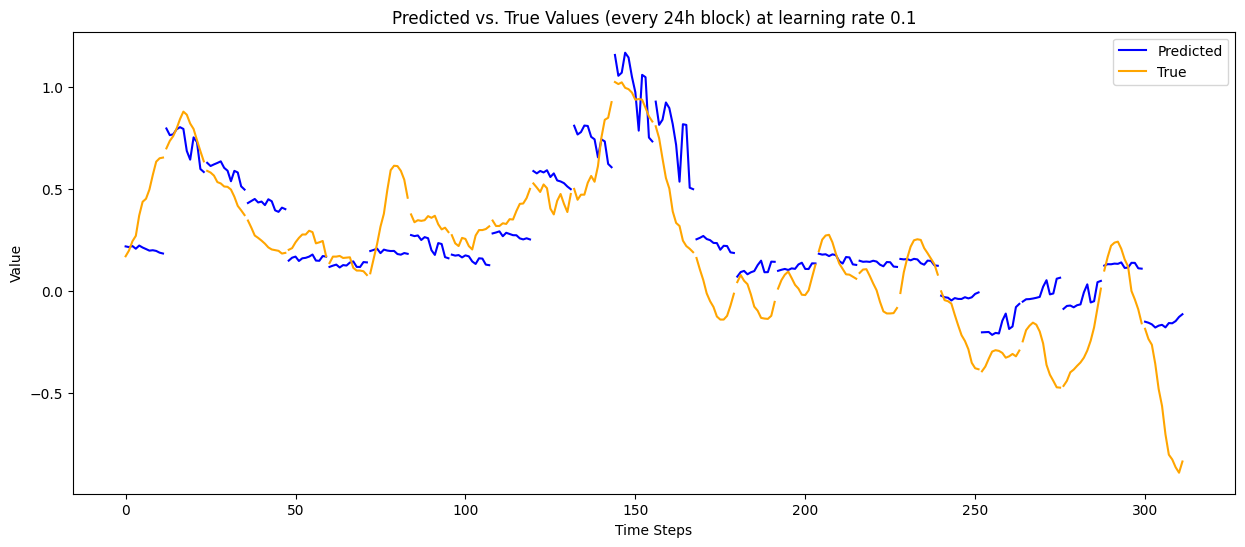

LR: 0.01

Shape of X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

Reshaped X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

| Epoch   1 | Train Loss: 0.6229 | Val Loss: 0.4768 | MSE Train: 0.2004 | MSE Val: 0.4768 | Time: 0.75s | Score Train: 0.3988 | Score Val: 0.5659 | 
| Epoch   2 | Train Loss: 0.1327 | Val Loss: 0.1752 | MSE Train: 0.0847 | MSE Val: 0.1752 | Time: 0.66s | Score Train: 0.4552 | Score Val: 0.4077 | 
| Epoch   3 | Train Loss: 0.0837 | Val Loss: 0.1111 | MSE Train: 0.0611 | MSE Val: 0.1111 | Time: 0.67s | Score Train: 0.4850 | Score Val: 0.3833 | 
| Epoch   4 | Train Loss: 0.0639 | Val Loss: 0.0848 | MSE Train: 0.0488 | MSE Val: 0.0848 | Time: 0.65s | Score Train: 0.4813 | Score Val: 0.3754 | 
| Epoch   5 | Train Loss: 0.0591 | Val Loss: 0.0637 | MSE Train: 0.0373 | MSE Val: 0.0637 | Time: 0.65s | Score Train: 0.4573 | Score Val: 0.3691 | 
| Epoch   6 | Train Loss: 0.0611 | Val Loss: 0.0637 | MSE Train: 0.0385 | MSE Val: 

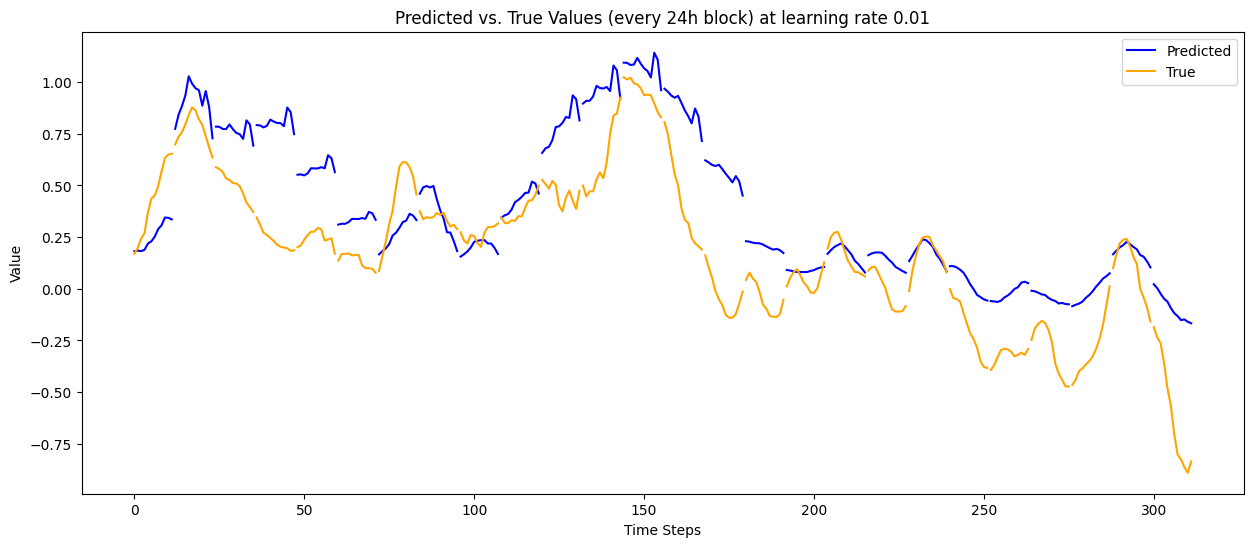

LR: 0.001

Shape of X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

Reshaped X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

| Epoch   1 | Train Loss: 0.2809 | Val Loss: 0.1060 | MSE Train: 0.0637 | MSE Val: 0.1060 | Time: 0.40s | Score Train: 0.4633 | Score Val: 0.3818 | 
| Epoch   2 | Train Loss: 0.1190 | Val Loss: 0.0677 | MSE Train: 0.0414 | MSE Val: 0.0677 | Time: 0.43s | Score Train: 0.4326 | Score Val: 0.3703 | 
| Epoch   3 | Train Loss: 0.0846 | Val Loss: 0.0555 | MSE Train: 0.0352 | MSE Val: 0.0555 | Time: 0.41s | Score Train: 0.4105 | Score Val: 0.3667 | 
| Epoch   4 | Train Loss: 0.0680 | Val Loss: 0.0453 | MSE Train: 0.0328 | MSE Val: 0.0453 | Time: 0.40s | Score Train: 0.3994 | Score Val: 0.3636 | 
| Epoch   5 | Train Loss: 0.0567 | Val Loss: 0.0384 | MSE Train: 0.0288 | MSE Val: 0.0384 | Time: 0.39s | Score Train: 0.3450 | Score Val: 0.3615 | 
| Epoch   6 | Train Loss: 0.0509 | Val Loss: 0.0290 | MSE Train: 0.0244 | MSE Val:

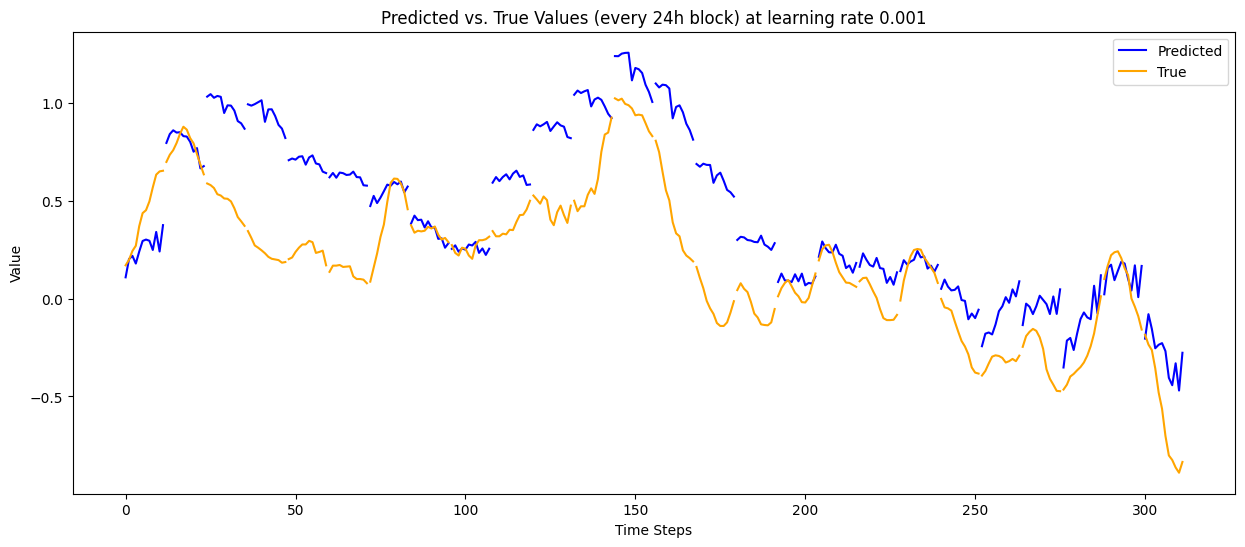

LR: 0.0001

Shape of X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

Reshaped X_train: torch.Size([18757, 24, 90]), y_train: torch.Size([18757, 12])

| Epoch   1 | Train Loss: 0.4197 | Val Loss: 0.0835 | MSE Train: 0.0521 | MSE Val: 0.0835 | Time: 0.72s | Score Train: 0.4531 | Score Val: 0.3751 | 
| Epoch   2 | Train Loss: 0.3229 | Val Loss: 0.0619 | MSE Train: 0.0464 | MSE Val: 0.0619 | Time: 0.67s | Score Train: 0.4250 | Score Val: 0.3686 | 
| Epoch   3 | Train Loss: 0.2776 | Val Loss: 0.0542 | MSE Train: 0.0368 | MSE Val: 0.0542 | Time: 0.65s | Score Train: 0.4279 | Score Val: 0.3663 | 
| Epoch   4 | Train Loss: 0.2432 | Val Loss: 0.0541 | MSE Train: 0.0337 | MSE Val: 0.0541 | Time: 0.67s | Score Train: 0.4412 | Score Val: 0.3662 | 
| Epoch   5 | Train Loss: 0.2141 | Val Loss: 0.0455 | MSE Train: 0.0307 | MSE Val: 0.0455 | Time: 0.66s | Score Train: 0.4305 | Score Val: 0.3636 | 
| Epoch   6 | Train Loss: 0.1874 | Val Loss: 0.0464 | MSE Train: 0.0295 | MSE Val

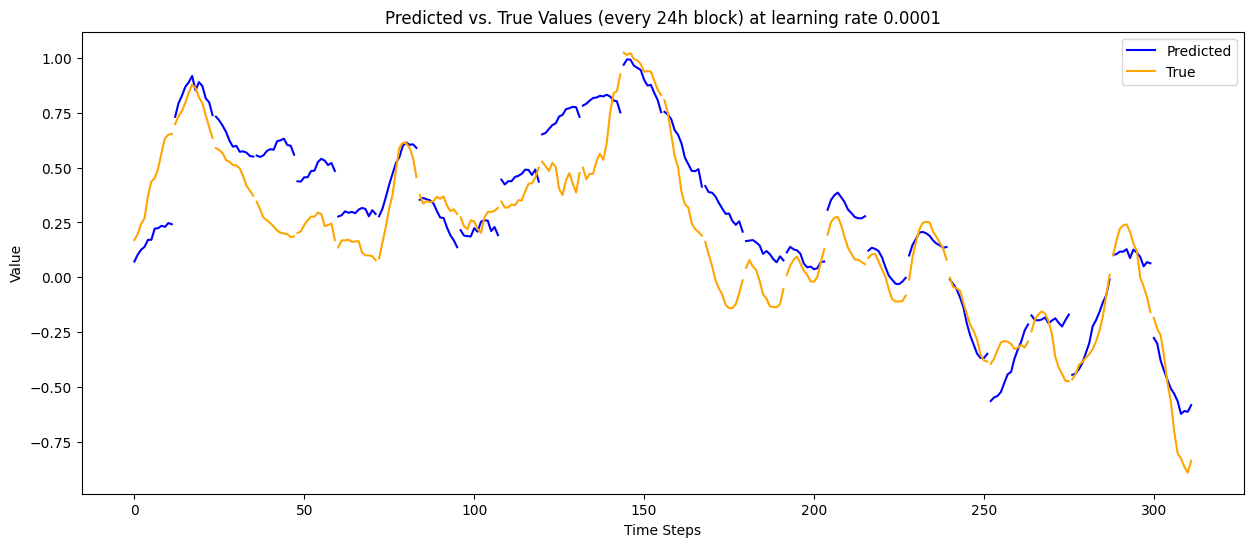

In [ ]:
import optuna
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class ClassicalNLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassicalNLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim //2)
        self.bn1 = nn.BatchNorm1d(input_dim //2)
        self.fc2 = nn.Linear(input_dim //2, input_dim //4)
        self.bn2 = nn.BatchNorm1d(input_dim //4)
        self.out = nn.Linear(input_dim //4, output_dim)

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.6)  # etwas stärkeres Dropout

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.out(x)
        return x


    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)




class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Activation
        self.relu = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim)
        
        
        # Take the last time step's output
        out = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)  # (batch_size, output_dim)

        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)




# Cross-Validation Zeitpunkte
folds = {
    # "Surge1": pd.Timestamp("2023-02-25 16:00:00"),
    # "Surge2": pd.Timestamp("2023-04-01 09:00:00"),
    # "Surge3": pd.Timestamp("2023-10-07 20:00:00"),
    # "Surge4": pd.Timestamp("2023-10-20 21:00:00"),
    # "Surge5": pd.Timestamp("2024-01-03 01:00:00"),
    # "Surge6": pd.Timestamp("2024-02-09 15:00:00"),
    "Surge7": pd.Timestamp("2024-12-09 10:00:00"),
    # "normal1": pd.Timestamp("2023-07-01 14:00:00"),
    # "normal2": pd.Timestamp("2024-04-01 18:00:00"),
    # "normal3": pd.Timestamp("2025-01-01 12:00:00"),
}

def create_sequences_pca(X_data: np.ndarray,  y_data: np.ndarray, seq_len=168, horizon=168, dtype=np.float32):
    """
    Erzeugt nur Sequenzen, die innerhalb eines zusammenhängenden Bereichs liegen.
    """

    X, y = [], []
    for i in range(len(X_data) - seq_len - horizon + 1):
        window_x = X_data[i : i + seq_len]
        window_y = y_data[i + seq_len : i + seq_len + horizon]



        # Sicherheitscheck: Kein NaN und Index ist lückenlos
        if np.any(np.isnan(window_x)) or np.any(np.isnan(window_y)):
            continue  # überspringen
        X.append(window_x)
        y.append(window_y)

    return np.array(X, dtype=dtype), np.array(y, dtype=dtype).reshape(-1, horizon)
# 0: 0 + 24 + 24
# 1: 1 + 24 + 24

# split data on folds
def cross_validation_loop(model_name, folds, X, y, time_delta, trial_params, trial:optuna.Trial=None, batch_size=32):
    
    fold_results = []
    for fold_name, fold_time in folds.items():
        start_cutoff = fold_time - time_delta
        end_cutoff = fold_time + time_delta
        print(f"Fold: {fold_name}, Start: {start_cutoff}, End: {end_cutoff}")

        # Split data into training and validation sets
        X_train = X[(X.index < start_cutoff) | (X.index > end_cutoff)]
        y_train = y[(y.index < start_cutoff) | (y.index > end_cutoff)]
        X_val = X[(X.index >= start_cutoff) & (X.index <= end_cutoff)]
        y_val = y[(y.index >= start_cutoff) & (y.index <= end_cutoff)]

        

        # Create gap around the fold time
        gap = 168
        gap_start = fold_time - pd.Timedelta(hours=gap)
        gap_end = fold_time + pd.Timedelta(hours=gap)

        X_val = X_val[(X_val.index >= gap_start) & (X_val.index <= gap_end)]
        y_val = y_val[(y_val.index >= gap_start) & (y_val.index <= gap_end)]

        # check if data contans NaN values
        if X_train.isnull().values.any() or y_train.isnull().values.any():
            print(f"NaN values found in training data for fold {fold_name}. Skipping this fold.")
            continue

        if X_val.isnull().values.any() or y_val.isnull().values.any():
            print(f"NaN values found in validation data for fold {fold_name}. Skipping this fold.")
            continue

        # create sequences
        X_train, y_train = create_sequences_pca(X_train.values, y_train.values, seq_len=SEQUENCE_LENGTH, horizon=HORIZON)
        X_val, y_val = create_sequences_pca(X_val.values, y_val.values, seq_len=SEQUENCE_LENGTH, horizon=HORIZON)

        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

        B_train, S_train, F_train = X_train.shape
        B_val, S_val, F_val = X_val.shape

        # Scale data
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train.reshape(B_train * S_train, F_train)).reshape(B_train, S_train, F_train)
        X_val_scaled = scaler_X.transform(X_val.reshape(B_val * S_val, F_val)).reshape(B_val, S_val, F_val)

        # convert to tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
        print(f"X_val_tensor shape: {X_val_tensor.shape}, y_val_tensor shape: {y_val_tensor.shape}")


        for lr in [0.1, 0.01, 0.001, 0.0001]:
            print("LR:", lr)
            model = ClassicalNLPModel(
                input_dim= X_train_tensor.shape[1] * X_train_tensor.shape[-1],  # Number of features
                #hidden_dim=128,
                output_dim=HORIZON
            )
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

            best_model = training_ConvLSTM_Regression_Classification_pca(
                model,
                X_train=X_train_tensor,  # Reshape to match input dimension
                y_train=y_train_tensor,
                X_val=X_val_tensor,  # Reshape to match input dimension
                y_val=y_val_tensor,
                epochs=1000,
                batch_size=batch_size,
                optimizer=optimizer,
                writer=None,
                verbose=True,
                log_tensorboard=False,
                patience=30,
                trial=trial,
                use_amp=False,
                classification_loss=False,
            )
            # check if cuda is available and move the model to the correct device

            best_model.to("cpu")
            predictions = best_model.predict(X_val_tensor)

            # Annahme: reg_out und y_test haben shape (961, 24)
            plt.figure(figsize=(15, 6))

            num_blocks = predictions.shape[0]

            for i in range(0, num_blocks, HORIZON):
                y_pred_block = predictions[i]
                y_true_block = y_val_tensor.cpu().numpy()[i]

                plt.plot(range(i, i + HORIZON), y_pred_block, label=f'Pred Block {i}', color='blue', alpha=1.0)
                plt.plot(range(i, i + HORIZON), y_true_block, label=f'True Block {i}', color='orange', alpha=1.0)

            plt.xlabel("Time Steps")
            plt.ylabel("Value")
            plt.title("Predicted vs. True Values (every 24h block) at learning rate " + str(lr))
            plt.legend(['Predicted', 'True'])
            plt.show()
        

cross_validation_loop(
    model_name="NLP",
    folds=folds,
    X=df_X,
    y=df_y,
    time_delta=pd.Timedelta(hours=168 * 4),
    trial_params=None,
    trial=None,
    batch_size=512*2
)

